# Introduction


![alt text](https://raw.githubusercontent.com/Fournierp/OCR/master/Digit%20Recognition/digits.png)

# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.ndimage as ndimage
import cv2

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import itertools

from collections import Counter

from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import backend as K
import tensorflow as tf

# Data Preprocessing

## Normalization & Reshape

To avoid exploding gradients in our CNN, we will normalize our data.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11501568/11490434 [==============================] - 0s 0us/step


## Categorization

The activation function of the last layer of our CNN will be a softmax function (which will tell the level of certainty with witch the model is about the categorization), so we will one hot encode the categories to achieve better results.

In [3]:
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

batch_size=32

dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=1024).batch(batch_size)

dataset_val = tf.data.Dataset.from_tensor_slices((x_test, y_test))
dataset_val = dataset_val.batch(batch_size)

# Model Design

In this model, we set the weights of the final layer to represent the distribution of the dataset. This is really useful for this unbalanced dataset (i.e. not a needed step for this one).

In [4]:
def build_model(input_shape, output_shape):
    x = Input(shape=input_shape)

    hidden = Conv2D(16, kernel_size=(5, 5), activation='relu', padding='same')(x)
    hidden = MaxPool2D(pool_size=2, strides=2)(hidden)

    hidden = Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(hidden)
    hidden = MaxPool2D(pool_size=2, strides=2)(hidden)

    hidden = Flatten()(hidden)
    hidden = Dense(128, activation='relu')(hidden)

    y = Dense(output_shape, activation='softmax')(hidden)

    return Model(inputs=x, outputs=y)

model = build_model((x_train.shape[1], x_train.shape[2], 1), 10)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               200832

## Custom Training Loop



In [5]:
class CustomModel(tf.keras.Model):
    def __init__(self, model, **kwargs):
        super(CustomModel, self).__init__(**kwargs)

        self.model = model

        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()

        self.acc = tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        self.loss_metric = tf.keras.metrics.Mean(name='loss')

    @property
    def metrics(self):
        return [
            self.acc,
            self.loss_metric
        ]

    @tf.function
    def test_step(self, data):
        x, y = data

        # Inference on test set
        y_pred = self.model(x, training=False)
        
        # Update metrics
        self.acc.update_state(y, y_pred)
        return {
            "Accuracy": self.acc.result(),
        }

    @tf.function
    def train_step(self, data):
        x_batch, y_batch = data

        # Forward pass
        with tf.GradientTape() as tape:
            y_pred = self.model(x_batch, training=True)
            total_loss = self.loss_fn(y_batch, y_pred)

        # Backpropagation
        grads = tape.gradient(total_loss, self.model.trainable_weights)

        # Weigth update
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        # Update training metric
        self.acc.update_state(y_batch, y_pred)
        self.loss_metric.update_state(total_loss)
        return {
            "Accuracy": self.acc.result(),
            "Categorical Cross Entropy": self.loss_metric.result(),
        }

In [6]:
optimizer = tf.keras.optimizers.Adam()

In [7]:
cm = CustomModel(model)
cm.compile(optimizer)
# cm.evaluate(dataset_train)

In [8]:
history = cm.fit(dataset_train, epochs=1, validation_data=dataset_val)

1875/1875 [==============================] - 38s 4ms/step - Accuracy: 0.9049 - Categorical Cross Entropy: 0.3125 - val_Accuracy: 0.9834


# Interpretability

Let's explore the outputs of some of the convolutional layers to determine if they are analysing noise or picking up on an actual signal.

In [9]:
def get_layer_output(model, idx, sample):
    assert idx < len(model.layers)
    assert idx > -2

    try:
        data_flow = K.function([model.layers[0].input],
                            [model.layers[idx].output])
        return data_flow(sample)
    except:
        print("Cannot get the layer")
        return None

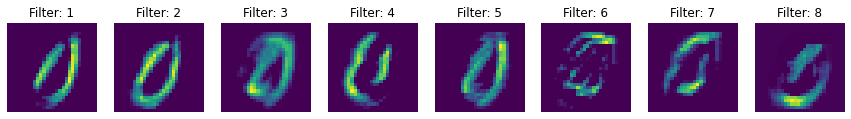

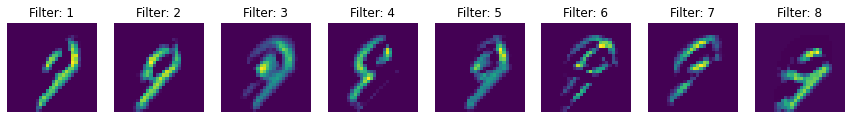

In [12]:
def show_vfeats(image1, image2, image3, image4, image5, image6, image7, image8):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(1, 8, figsize=(15,15))
    ax1.axis('off'), ax2.axis('off'), ax3.axis('off'), ax4.axis('off')
    ax5.axis('off'), ax6.axis('off'), ax7.axis('off'), ax8.axis('off')

    g = ax1.imshow(image1)
    ax1.set_title(f'Filter: {1}')
    g = ax2.imshow(image2)
    ax2.set_title(f'Filter: {2}')
    g = ax3.imshow(image3)
    ax3.set_title(f'Filter: {3}')
    g = ax4.imshow(image4)
    ax4.set_title(f'Filter: {4}')
    g = ax5.imshow(image5)
    ax5.set_title(f'Filter: {5}')
    g = ax6.imshow(image6)
    ax6.set_title(f'Filter: {6}')
    g = ax7.imshow(image7)
    ax7.set_title(f'Filter: {7}')
    g = ax8.imshow(image8)
    ax8.set_title(f'Filter: {8}')

for image, label in dataset_train.take(2):
    vfeat = get_layer_output(model, 1, image)[0]

    show_vfeats(
        np.reshape(vfeat[0, :, :, 0], (28, 28)),
        np.reshape(vfeat[0, :, :, 1], (28, 28)),
        np.reshape(vfeat[0, :, :, 2], (28, 28)),
        np.reshape(vfeat[0, :, :, 3], (28, 28)),
        np.reshape(vfeat[0, :, :, 4], (28, 28)),
        np.reshape(vfeat[0, :, :, 5], (28, 28)),
        np.reshape(vfeat[0, :, :, 6], (28, 28)),
        np.reshape(vfeat[0, :, :, 7], (28, 28))
        )

# Model Evaluation

Let us look at where the model is wrong with the confusion matrix (we will see if patterns of errors are recurrent).

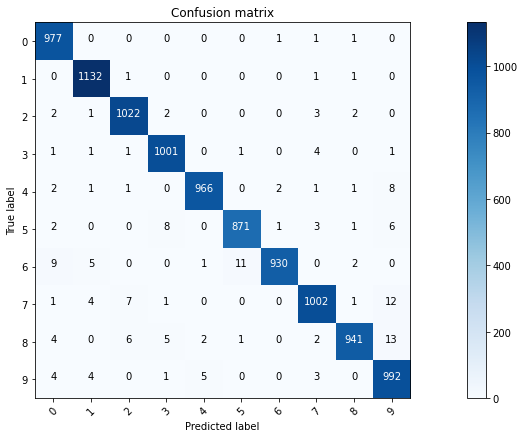

In [13]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(16,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

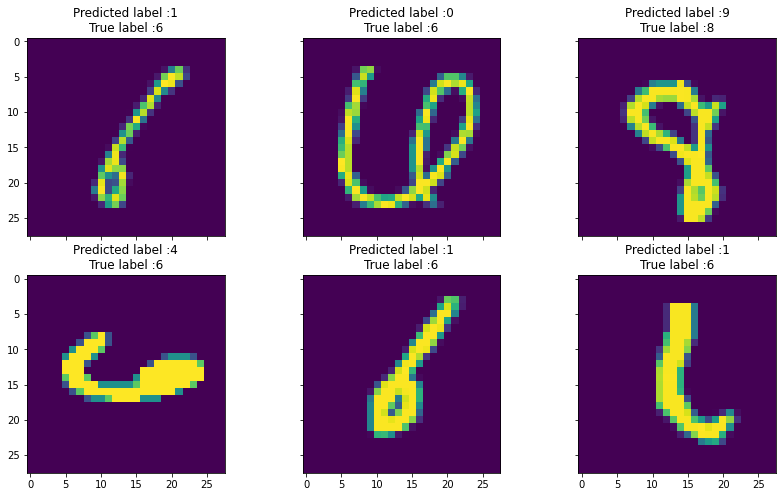

In [14]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(14,8))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)

# Adverserial Attacks

Optimize a noise pattern with backpropagated gradients obtained from maximizing missclassification error and minimizing the image noise.

In [15]:
def adverserary_noise(target_cls, num_iterations=100, noise_limit = 0.35, noise_l2_weight = 0.02):
    noise = tf.Variable(tf.zeros([28, 28, 1]),
                  name='x_noise', trainable=True)
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

    for i in range(num_iterations):
        for image, label in dataset_train.take(1):
            image = tf.constant(image, dtype=tf.float32)
            # Get a batch of labels for target class
            y_true_batch = np.zeros_like(label)
            y_true_batch[:, target_cls] = 1.0

            # Forward pass
            with tf.GradientTape() as tape:
                # Watch operations done to noise image
                tape.watch(noise)
                # Add noise to image
                noisy_image = image + noise
                noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)
                # Infer noisy image's class
                y_pred = model(noisy_image, training=False)
                # Classification loss: maximize the number of classifications as the target
                ccloss = tf.keras.losses.CategoricalCrossentropy()(y_true_batch, y_pred)
                # L2-Loss: minimize the amount of noise 
                l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(noise)
                loss_adversary = ccloss + l2_loss_noise

            # Backpropagation
            grads = tape.gradient(loss_adversary, noise)

            # Weigth update
            opt.apply_gradients([(grads, noise)])
            noise.assign(tf.clip_by_value(noise, -noise_limit, noise_limit))

        # Print status every 100 iterations.
        if (i % 1000 == 0) or (i == num_iterations - 1):
            correct = np.argmax(y_pred, axis=1) == np.argmax(label, axis=1)
            acc = float(np.sum(correct)) / len(label)

            msg = "Iteration: {0} - Accuracy: {1:.1%}"
            print(msg.format(i, acc))

    return noise

ad_noise = adverserary_noise(target_cls=0, num_iterations=4000)

Iteration: 0 - Accuracy: 93.8%
Iteration: 1000 - Accuracy: 28.1%
Iteration: 2000 - Accuracy: 31.2%
Iteration: 3000 - Accuracy: 28.1%
Iteration: 3999 - Accuracy: 53.1%


Noise:
- Min: -0.35
- Max: 0.35
- Mean: -0.005326779
- Variance: 0.07690245


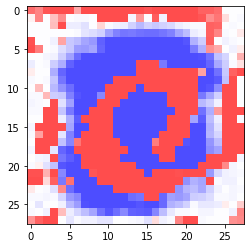

In [16]:
def plot_noise(noise):
    print("Noise:")
    print("- Min:", np.min(noise))
    print("- Max:", np.max(noise))
    print("- Mean:", np.mean(noise))
    print("- Variance:", np.var(noise))

    plt.imshow(noise[:, :, 0], interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)
    
plot_noise(ad_noise.numpy())

In [17]:
def plot_images(images, noise, y_true, y_pred):
    assert len(images) == len(y_true) == 9
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        image = images[i]
        # Add the noise
        image += noise
        image = np.clip(image, 0.0, 1.0)

        # Plot image.
        ax.imshow(image[:, :, 0],
                  cmap='binary', interpolation='nearest')

        # Show true and predicted classes.
        xlabel = "True: {0}, Pred: {1}".format(np.argmax(y_true[i]), np.argmax(y_pred[i]))
        ax.set_xlabel(xlabel)        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [18]:
def plot_example_errors(y_pred, correct, images, labels, noise):
    incorrect = (correct == False)
    y_pred = y_pred[incorrect]
    y_true = labels[incorrect]

    plot_images(images=images[0:9],
                y_true=y_true[0:9],
                y_pred=y_pred[0:9],
                noise=noise)

In [19]:
def print_test_accuracy():    
    noise = ad_noise
    for images, labels in dataset_train.take(1):
        # Add noise to the images
        images += noise
        images = np.clip(images, 0.0, 1.0)
        # Inference
        y_pred = model.predict(images)

    # Accuracy metrics
    correct = np.argmax(labels, axis=1) == np.argmax(y_pred, axis=1)
    acc = float(correct.sum()) / len(labels)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct.sum(), len(labels)))

    print("Example errors:")
    plot_example_errors(y_pred, correct, images, labels, noise)

Accuracy on Test-Set: 31.2% (10 / 32)
Example errors:


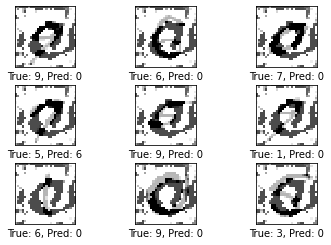

In [20]:
print_test_accuracy()